In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from shapely.geometry.polygon import LinearRing
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
#load the census tract shapefiles
tracts_2000 = Reader(os.path.join('..', 'shapefiles', '2000_census_tracts_geoid.shp'))
tracts_2010 = Reader(os.path.join('..', 'shapefiles', 'austin_metro_tracts.shp'))
counties = Reader(os.path.join('..', 'shapefiles', 'austin_metro_counties.shp'))

#get number of tracts in each shapefile
n_2000 = sum(1 for _ in tracts_2000.geometries())
n_2010 = sum(1 for _ in tracts_2010.geometries())

#get the geoids for the 2000 census tracts
tract_list_2000 = [x.attributes['GEOID'] for x in tracts_2000.records()]
#get the geoids for the 2010 census tracts
tract_list_2010 = [x.attributes['GEOID'] for x in tracts_2010.records()]

#sanity check
assert len(tract_list_2000) == n_2000
assert len(tract_list_2010) == n_2010

#get the data for which tracts changed by more than 5%
#the csv was created and saved in the data preprocessing notebook
changed = pd.read_csv(os.path.join('..', 'shapefiles', 'need_to_change.csv'), index_col=0)
#multiple tracts -> single tract from 2000 to 2010
merged = changed[(changed['poppct00'] > 95) & (changed['poppct10'] < 100)]
#single tract -> multiple tracts from 2000 to 2010
split = changed[changed['poppct10'] > 95]

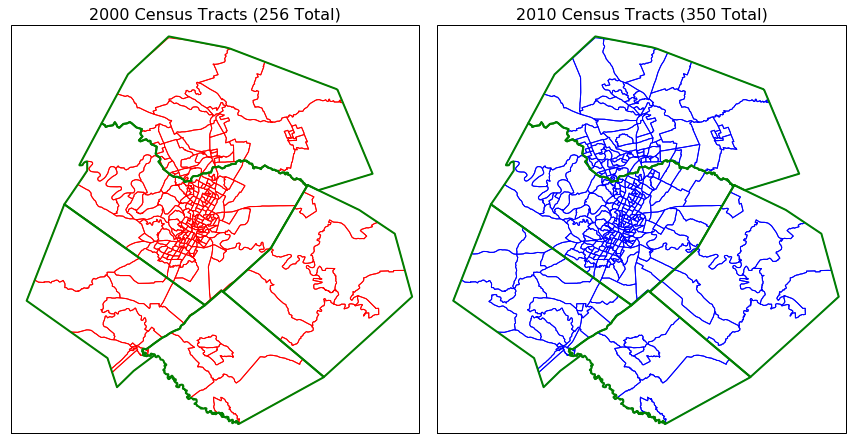

In [3]:
extent = [-98.35, -97, 29.6, 30.95]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.Miller()})

ax1.set_extent(extent, ccrs.Miller())
ax1.add_geometries(tracts_2000.geometries(), ccrs.Miller(), facecolor='none', edgecolor='red')
ax1.add_geometries(counties.geometries(), ccrs.Miller(), facecolor='none', edgecolor='green', linewidth=2)
ax1.set_title('2000 Census Tracts ({} Total)'.format(n_2000), fontdict={'fontsize': 16})

ax2.set_extent(extent, ccrs.Miller())
ax2.add_geometries(tracts_2010.geometries(), ccrs.Miller(), facecolor='none', edgecolor='blue')
ax2.add_geometries(counties.geometries(), ccrs.Miller(), facecolor='none', edgecolor='green', linewidth=2)
ax2.set_title('2010 Census Tracts ({} Total)'.format(n_2010), fontdict={'fontsize': 16})

fig.tight_layout()

plt.savefig(os.path.join('..', 'figures', 'census_tracts.png'), dpi=500)

C:\Users\tsansom\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


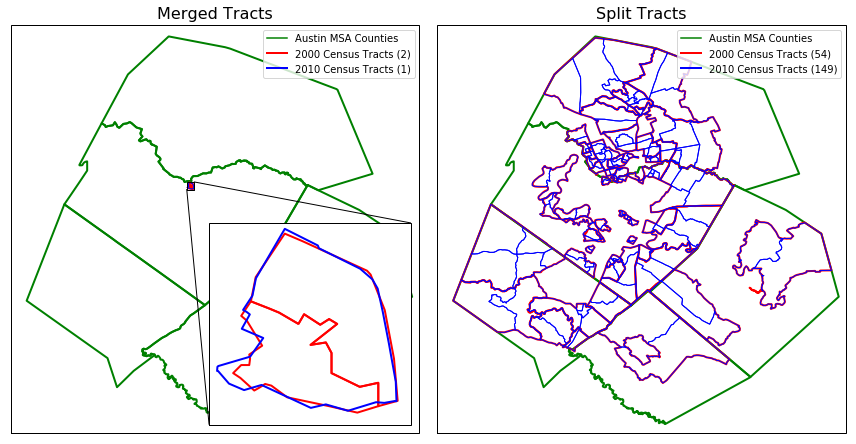

In [4]:
merged_geoms = {'2000': [], '2010': []}
split_geoms = {'2000': [], '2010': []}
for r, g in zip(tracts_2000.records(), tracts_2000.geometries()):
    if int(r.attributes['GEOID']) in set(merged['geoid00']):
        merged_geoms['2000'].append(g)
    if int(r.attributes['GEOID']) in set(split['geoid00']):
        split_geoms['2000'].append(g)
for r, g in zip(tracts_2010.records(), tracts_2010.geometries()):
    if int(r.attributes['GEOID']) in set(merged['geoid10']):
        merged_geoms['2010'].append(g)
    if int(r.attributes['GEOID']) in set(split['geoid10']):
        split_geoms['2010'].append(g)
    #this is the austin-bergstrom airport tract (not part of relation file - zero population)
    if int(r.attributes['GEOID']) == 48453980000:
        split_geoms['2010'].append(g)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.Miller()})

inset_extent = [-97.7686, -97.7435, 30.405, 30.43]
inset_lons = [inset_extent[0], inset_extent[0], 
              inset_extent[1], inset_extent[1]]
inset_lats = [inset_extent[2], inset_extent[3],
              inset_extent[3], inset_extent[2]]
inset = LinearRing(list(zip(inset_lons, inset_lats)))

ax1.set_extent(extent, ccrs.Miller())
ax1.add_geometries(merged_geoms['2000'], ccrs.Miller(), facecolor='none', edgecolor='red', linewidth=2)
ax1.add_geometries(merged_geoms['2010'], ccrs.Miller(), facecolor='none', edgecolor='blue')
ax1.add_geometries(counties.geometries(), ccrs.Miller(), facecolor='none', edgecolor='green', zorder=0, linewidth=2)
ax1.add_geometries([inset], ccrs.Miller(), facecolor='none', edgecolor='black')
ax1_inset = fig.add_axes([0.188, 0.16, 0.35, 0.35], projection=ccrs.Miller())
ax1.plot([inset_extent[0], -97.695], [inset_extent[2], 29.63], c='k', linewidth=1)
ax1.plot([inset_extent[1], -97.03], [inset_extent[3], 30.2949], c='k', linewidth=1)
ax1_inset.set_extent(inset_extent, ccrs.Miller())
ax1_inset.add_geometries(merged_geoms['2000'], ccrs.Miller(), facecolor='none', edgecolor='red', linewidth=2)
ax1_inset.add_geometries(merged_geoms['2010'], ccrs.Miller(), facecolor='none', edgecolor='blue', linewidth=2)

#need to make line proxies to add a legend
m00 = mlines.Line2D([], [], color='red', linewidth=2)
m10 = mlines.Line2D([], [], color='blue', linewidth=2)
c10 = mlines.Line2D([], [], color='green')
ax1.legend([c10, m00, m10], ['Austin MSA Counties', 
                             '2000 Census Tracts ({})'.format(len(merged_geoms['2000'])), 
                             '2010 Census Tracts ({})'.format(len(merged_geoms['2010']))])
ax1.set_title('Merged Tracts', fontdict={'fontsize': 16})

ax2_extent = [-98.35, -97, 28.88, 30.05]
ax2.set_extent(extent, ccrs.Miller())
ax2.add_geometries(split_geoms['2000'], ccrs.Miller(), facecolor='none', edgecolor='red', linewidth=2)
ax2.add_geometries(split_geoms['2010'], ccrs.Miller(), facecolor='none', edgecolor='blue')
ax2.add_geometries(counties.geometries(), ccrs.Miller(), facecolor='none', edgecolor='green', zorder=0, linewidth=2)
ax2.legend([c10, m00, m10], ['Austin MSA Counties', 
                             '2000 Census Tracts ({})'.format(len(split_geoms['2000'])), 
                             '2010 Census Tracts ({})'.format(len(split_geoms['2010']))])
ax2.set_title('Split Tracts', fontdict={'fontsize': 16})

fig.tight_layout()

plt.savefig(os.path.join('..', 'figures', 'merged_split_tracts.png'), dpi=500)